This notebook is for copmparing local source (LS) fire data (polygons) with Breezometer (BRZ) fire polygons, by SJOIN intersection

Two GeoPackages are created:

1. No LS-BRZ fire polygon intersection -> records only the 'missing' LS event details
2. LS-BRZ intersection -> records LS and BRZ event details

In [1]:
from brz_storage_lib.download import Download
from datetime import datetime, timedelta
from shapely.validation import make_valid
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.wkt import loads

import pandas as pd
import pandas_gbq
import geopandas as gpd
import os
import fiona
import io
import json
import itertools

# for progress monitoring
import tqdm
from tqdm import tqdm

# for data plotting / mapping / exploring
import folium
import matplotlib
import mapclassify

# for BQ query (for BRZ fire polygons)
from geopandas import GeoDataFrame
from google.cloud import bigquery

# class to extend JSON encoder to convert timestamp columns to string values
class PdEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.Timestamp):
            return str(obj)
        return json.JSONEncoder.default(self, obj)



[gdf_LS_spatial_bounds type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_spatial_bounds.is_valid]:
True

[gdf_LS_spatial_bounds]:
     UniqueSourceEventId  SourceId           SourceName  \
0          BC_CAN_N11064    BC_CAN  BC_Wildfire_Service   
1          BC_CAN_N12113    BC_CAN  BC_Wildfire_Service   
2          BC_CAN_N40903    BC_CAN  BC_Wildfire_Service   
3          BC_CAN_N41683    BC_CAN  BC_Wildfire_Service   
4          BC_CAN_N41684    BC_CAN  BC_Wildfire_Service   
...                  ...       ...                  ...   
1129     WAFS_AUS_590291  WAFS_AUS         Emergency WA   
1130     WAFS_AUS_590011  WAFS_AUS         Emergency WA   
1131     WAFS_AUS_589866  WAFS_AUS         Emergency WA   
1132     WAFS_AUS_589832  WAFS_AUS         Emergency WA   
1133     WAFS_AUS_589659  WAFS_AUS         Emergency WA   

                                       SourceURL SourceEventId  \
0        https://www2.gov.bc.ca/gov/content/home        N11064   
1        https:

<AxesSubplot:>

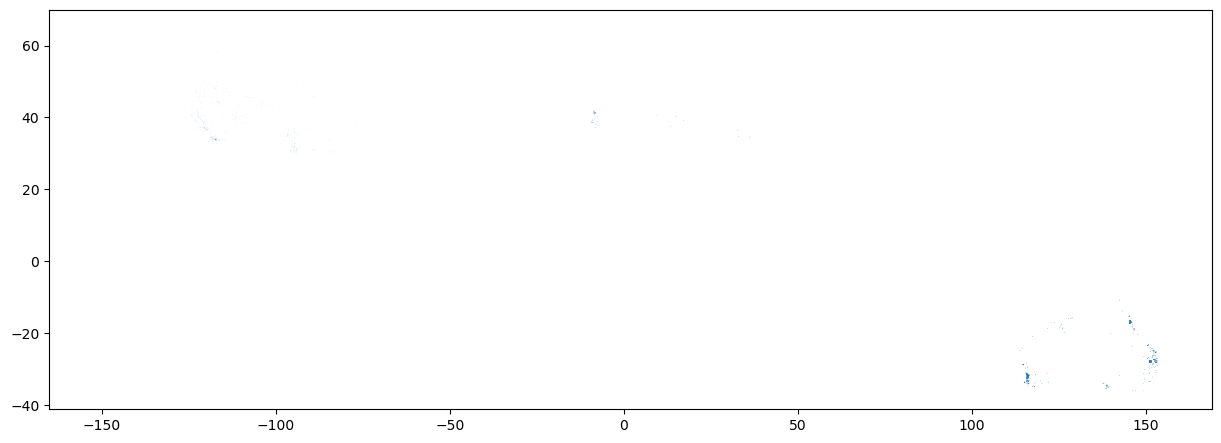

In [2]:
# Load gpkg to GeoDataFrame for all files

gdf_LS_spatial_bounds = []

gpkg_name = 'gdf_LS_spatial_bounds_2022-10-01T00:00:00_2022-10-02T00:00:00.gpkg'

gdf_LS_spatial_bounds = gpd.read_file(gpkg_name)

gdf_LS_spatial_bounds.set_geometry('geometry', drop=False, inplace=False, crs=4326)

print('\n\n[gdf_LS_spatial_bounds type]:')
print(type(gdf_LS_spatial_bounds))
print('\n[gdf_LS_spatial_bounds.is_valid]:')
print(gdf_LS_spatial_bounds.is_valid.all())
print('\n[gdf_LS_spatial_bounds]:')
print(gdf_LS_spatial_bounds)

# create a plot of the GDF
gdf_LS_spatial_bounds.plot(figsize=(15,15))

In [3]:
# Select relevant fire polygon data from BigQuery to (spatial) intersect with local source data

client = bigquery.Client(project='brz-fires') # *** NEED TO FIGURE OUT PERMISSIONS TO USE BRZ-BQ-SLOTS PROJECT INSTEAD

# add new gdf colum for intersection results (to be filled with 'None' if no BRZ fire intersects or EventID from BRZ fire poly if intersection)
# gdf_LS_spatial_bounds['common_fire'] = ''

# create a new dataframe for the LS-BRZ intersection output
gdf_LS_BRZ_intersection = pd.DataFrame()
gdf_LS_BRZ_no_intersection = pd.DataFrame()

# get the number of local source events for progress bar
num_LS_compare = len(gdf_LS_spatial_bounds.index)
# print(num_LS_compare)

# setup progress bar for total progress
pbar_compare_total = tqdm(total=num_LS_compare, desc="Total Compare Progress:", position=0, leave=True, colour="green")

# print('\nindex, CompareDateTime, minCompareDateTime, maxCompareDateTime, minlat, minlong, maxlat, maxlong')

for i, row in enumerate(gdf_LS_spatial_bounds.itertuples(), 0):
    
    CompareDateTime = pd.to_datetime(gdf_LS_spatial_bounds.iloc[i]['CompareDateTime'])
    minCompareDateTime = pd.to_datetime(gdf_LS_spatial_bounds.iloc[i]['minCompareDateTime'])
    maxCompareDateTime = pd.to_datetime(gdf_LS_spatial_bounds.iloc[i]['maxCompareDateTime'])
    minlat = gdf_LS_spatial_bounds.iloc[i]['minlat']
    minlong = gdf_LS_spatial_bounds.iloc[i]['minlong']
    maxlat = gdf_LS_spatial_bounds.iloc[i]['maxlat']
    maxlong = gdf_LS_spatial_bounds.iloc[i]['maxlong']
    
    # print( i, CompareDateTime, minCompareDateTime, maxCompareDateTime, minlat, minlong, maxlat, maxlong)
        
    # set up SQL query
    sql = f"""
        SELECT * FROM `brz-fires.views.fires_ds_view`
        WHERE 
            DATETIME(ts) between '{minCompareDateTime}' and '{maxCompareDateTime}' and
            CurrentLat between {minlat} and {maxlat} and
            CurrentLon between {minlong} and {maxlong}
        
        QUALIFY ROW_NUMBER() OVER (PARTITION BY EventId, LastUpdated ORDER BY ts) = 1
        ORDER BY EventId
    
    """
    # print('\n[SQL brz-fires.views.fires_ds_view]:')
    # print(sql)
    
    # Query BQ and generate GeoDataFrame from returned query results
    df_tmp_BRZ = client.query(sql).to_dataframe() # results of query to DataFrame

    # use geometry from 'ShapeAccum' column
    # ShapeAccum_geom = gpd.GeoSeries.from_wkt(df_tmp_BRZ['ShapeAccum']) # extract column of geometry from WKT
    # gdf_tmp_BRZ = gpd.GeoDataFrame(df_tmp_BRZ, geometry=ShapeAccum_geom, crs="EPSG:4326") # convert DataFrame to GeoDataFrame 

    # use geometry from 'Shape' column
    # Shape_geom = gpd.GeoSeries.from_wkt(df_tmp_BRZ['Shape']) # extract column of geometry from WKT
    # gdf_tmp_BRZ = gpd.GeoDataFrame(df_tmp_BRZ, geometry=Shape_geom, crs="EPSG:4326") # convert DataFrame to GeoDataFrame 
    
    # creating a WKT column which uses 'ShapeAccum' as first priority, but if this is NULL then use 'Shape' column data
    # df_tmp_BRZ["WKT"] = df_tmp_BRZ["ShapeAccum"].fillna(df_tmp_BRZ["Shape"])

    # creating a WKT column which uses 'Shape' as first priority, but if this is NULL then use 'ShapeAccum' column data
    df_tmp_BRZ["WKT"] = df_tmp_BRZ["Shape"].fillna(df_tmp_BRZ["ShapeAccum"])

    BRZ_geom = gpd.GeoSeries.from_wkt(df_tmp_BRZ['WKT']) # extract column of geometry from WKT
    gdf_tmp_BRZ = gpd.GeoDataFrame(df_tmp_BRZ, geometry=BRZ_geom, crs="EPSG:4326") # convert DataFrame to GeoDataFrame 

    # Fix geometries - buffer method
    gdf_tmp_BRZ['geometry'].buffer(0).is_valid.all()

    # Fix geometries - make_valid method
    # gdf_tmp_BRZ.geometry = gdf_tmp_BRZ.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)

    # print('\n[gdf_tmp_BRZ type]:')
    # print(type(gdf_tmp_BRZ))
    # print('\n[gdf_tmp_BRZ.is_valid]:')
    # print(gdf_tmp_BRZ.is_valid.all())
    # print('\n[gdf_tmp_BRZ]:')
    # print(gdf_tmp_BRZ)

    # create temporary dataframe for current LS row
    gdf_tmp_LS = gdf_LS_spatial_bounds.iloc[[i]]
    
    # print('\n[gdf_tmp_LS type]:')
    # print(type(gdf_tmp_LS))
    # print('\n[gdf_tmp_LS.is_valid]:')
    # print(gdf_tmp_LS.is_valid.all())
    # print('\n[gdf_tmp_LS]:')
    # print(gdf_tmp_LS)

    # ---------------------------------------------------
    
    # Project BRZ to Google Maps Global Mercator -- Spherical Mercator projected crs
    # gdf_tmp_BRZ_Merc = gdf_tmp_BRZ.to_crs(epsg=900913)

    # print('\n[gdf_tmp_BRZ_Merc type]:')
    # print(type(gdf_tmp_BRZ_Merc))
    # print('\n[gdf_tmp_BRZ_Merc.is_valid]:')
    # print(gdf_tmp_BRZ_Merc.is_valid.all())
    # print('\n[gdf_tmp_BRZ_Merc]:')
    # print(gdf_tmp_BRZ_Merc)

    # Project LS to Google Maps Global Mercator -- Spherical Mercator projected crs
    # gdf_tmp_LS_Merc = gdf_tmp_LS.to_crs(epsg=900913)

    # print('\n[gdf_tmp_LS_Merc type]:')
    # print(type(gdf_tmp_LS_Merc))
    # print('\n[gdf_tmp_LS_Merc.is_valid]:')
    # print(gdf_tmp_LS_Merc.is_valid.all())
    # print('\n[gdf_tmp_LS_Merc]:')
    # print(gdf_tmp_LS_Merc)
    
    # ---------------------------------------------------
    
    # Intersection of lS and BRZ polygons - with projected GDFs
    
    # common_fire_tmp_Merc = gpd.sjoin(gdf_tmp_LS_Merc, gdf_tmp_BRZ_Merc, how='inner', predicate='intersects', lsuffix='LS', rsuffix='BRZ')
    # print('\n[common_fire_tmp_Merc type]:')
    # print(type(common_fire_tmp_Merc))
    # print('\n[common_fire_tmp_Merc]:')
    # print(common_fire_tmp_Merc)
    
    # Project to Geographica Coords crs
    # common_fire_tmp = common_fire_tmp_Merc.to_crs(epsg=4326)
    
    # ---------------------------------------------------
    
    # Intersection of lS and BRZ polygons - with geographical GDFs
    common_fire_tmp = gpd.sjoin(gdf_tmp_LS, gdf_tmp_BRZ, how='inner', predicate='intersects', lsuffix='LS', rsuffix='BRZ')
    # print('\n[common_fire_tmp type]:')
    # print(type(common_fire_tmp))
    # print('\n[common_fire_tmp]:')
    # print(common_fire_tmp)

    # if no intersection then returns empty GDF (common_fire_tmp)
    if common_fire_tmp.empty:

        # print('\nno common fire intersection found')

        gdf_LS_BRZ_no_intersection = gdf_LS_BRZ_no_intersection.append(gdf_tmp_LS) # in this case the common_fire_tmp GDF is empty so use details from gdf_tmp_LS
        
        # print('\n[gdf_LS_BRZ_no_intersection type]:')
        # print(type(gdf_LS_BRZ_no_intersection))
        # print('\n[gdf_LS_BRZ_no_intersection]:')
        # print(gdf_LS_BRZ_no_intersection)

        # input("Press Enter to continue...")
        
    else: # if intersection between LS and BRZ fire polygon(s) found

        # print('\ncommon fire intersection found')
        
        gdf_LS_BRZ_intersection = gdf_LS_BRZ_intersection.append(common_fire_tmp)
        
        # print('\n[gdf_LS_BRZ_intersection type]:')
        # print(type(gdf_LS_BRZ_intersection))
        # print('\n[gdf_LS_BRZ_intersection]:')
        # print(gdf_LS_BRZ_intersection)

        # input("Press Enter to continue...")
        
    # update progress bars
    pbar_compare_total.update(1)
    
pbar_compare_total.close()

Total Compare Progress:: 100%|██████████| 1134/1134 [59:05<00:00,  3.13s/it] 



[world dataset]:
<class 'geopandas.geodataframe.GeoDataFrame'>
       pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   


<AxesSubplot:>

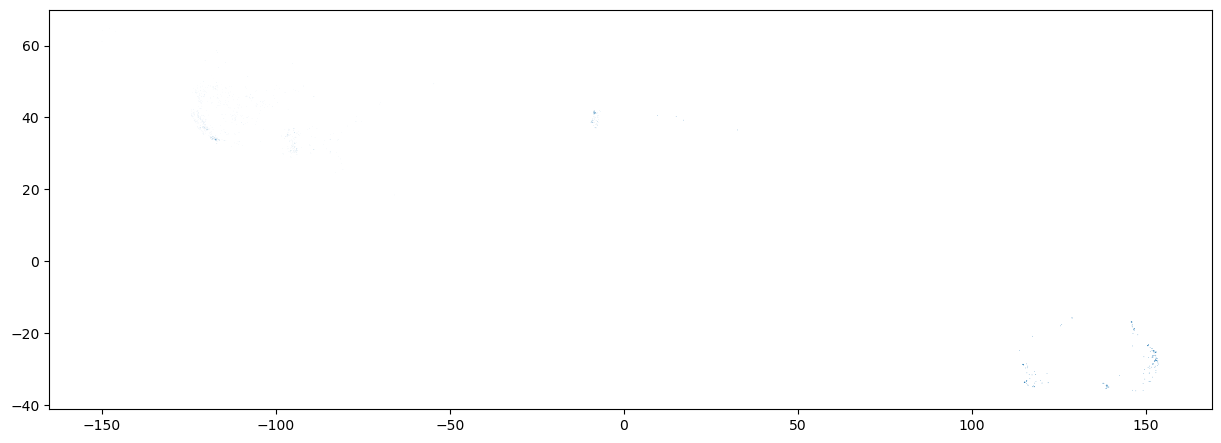

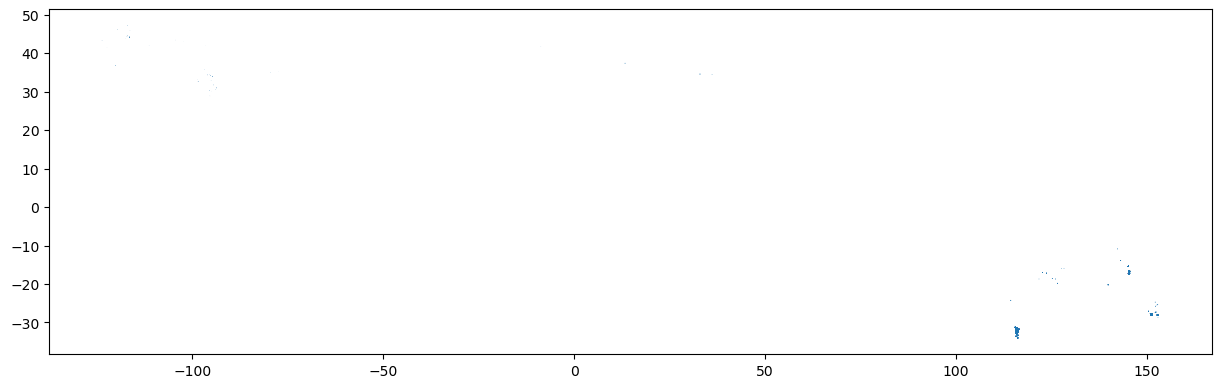

In [4]:
# adding "continent, country, country_code" to [intersection] and [no_intersection] geodataframes, based on shape 'contains' spatial join

gdf_world = gpd.GeoDataFrame(gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')), crs="EPSG:4326") # default world dataset is a GeoSeries so needs to be converetd to GeoDataFrame
print('\n[world dataset]:')
print(type(gdf_world))
print(gdf_world)

del gdf_world['pop_est']
del gdf_world['gdp_md_est']
gdf_world.rename(columns = {'name':'country', 'iso_a3':'country_code'}, inplace = True)
print('\n\n[world dataset modified]:')
print(gdf_world)

# Add attributes by spatial join
gdf_LS_BRZ_no_intersection_world = gpd.sjoin(gdf_world, gdf_LS_BRZ_no_intersection, how='right', predicate='contains', lsuffix='WLD', rsuffix='LS')
del gdf_LS_BRZ_no_intersection_world['index_WLD']

print('\n\n[gdf_LS_BRZ_no_intersection_world.is_valid]:')
print(gdf_LS_BRZ_no_intersection_world.is_valid.all())
print('\n[gdf_LS_BRZ_no_intersection_world type]:')
print(type(gdf_LS_BRZ_no_intersection_world))
print('\n[gdf_LS_BRZ_no_intersection_world]:')
print(gdf_LS_BRZ_no_intersection_world)

# create a plot of the GDF (no intersection)
gdf_LS_BRZ_no_intersection_world.plot(figsize=(15,15))

# Add attributes by spatial join
gdf_LS_BRZ_intersection_world = gpd.sjoin(gdf_world, gdf_LS_BRZ_intersection, how='right', predicate='contains', lsuffix='WLD', rsuffix='LS')
del gdf_LS_BRZ_intersection_world['index_WLD']

print('\n\n[gdf_LS_BRZ_intersection_world.is_valid]:')
print(gdf_LS_BRZ_intersection_world.is_valid.all())
print('\n[gdf_LS_BRZ_intersection_world type]:')
print(type(gdf_LS_BRZ_intersection_world))
print('\n[gdf_LS_BRZ_intersection_world]:')
print(gdf_LS_BRZ_intersection_world)

# create a plot of the GDF (intersection)
gdf_LS_BRZ_intersection_world.plot(figsize=(15,15))



[gdf_LS_BRZ_no_intersection type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_BRZ_no_intersection.is_valid]:
True

[gdf_LS_BRZ_no_intersection]:
     UniqueSourceEventId  SourceId           SourceName  \
0          BC_CAN_N11064    BC_CAN  BC_Wildfire_Service   
1          BC_CAN_N12113    BC_CAN  BC_Wildfire_Service   
2          BC_CAN_N40903    BC_CAN  BC_Wildfire_Service   
3          BC_CAN_N41683    BC_CAN  BC_Wildfire_Service   
4          BC_CAN_N41684    BC_CAN  BC_Wildfire_Service   
...                  ...       ...                  ...   
1126     WAFS_AUS_590319  WAFS_AUS         Emergency WA   
1128     WAFS_AUS_590296  WAFS_AUS         Emergency WA   
1129     WAFS_AUS_590291  WAFS_AUS         Emergency WA   
1130     WAFS_AUS_590011  WAFS_AUS         Emergency WA   
1133     WAFS_AUS_589659  WAFS_AUS         Emergency WA   

                                       SourceURL SourceEventId  \
0        https://www2.gov.bc.ca/gov/content/home        N11064   


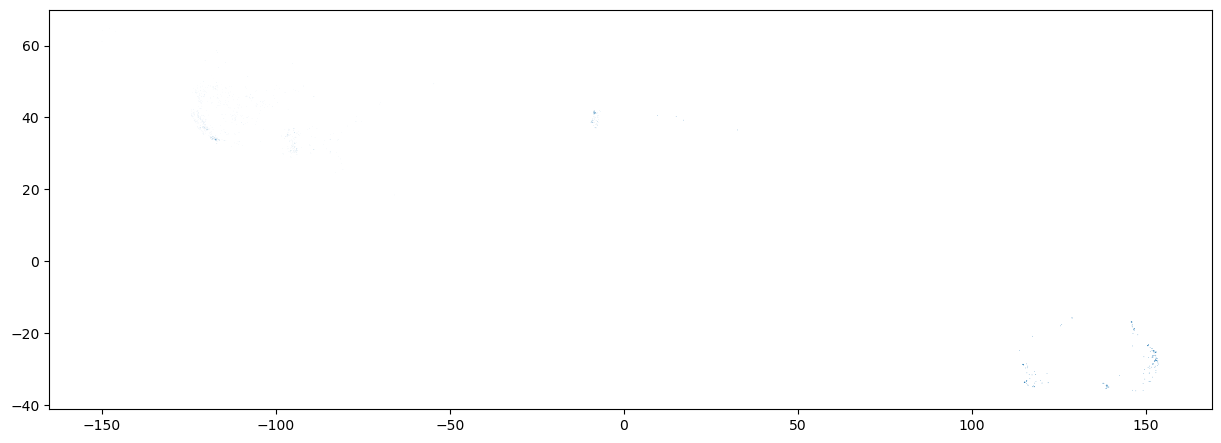

In [5]:
# Export 'no intersection' GeoDataFrame to file

print('\n\n[gdf_LS_BRZ_no_intersection type]:')
print(type(gdf_LS_BRZ_no_intersection))
print('\n[gdf_LS_BRZ_no_intersection.is_valid]:')
print(gdf_LS_BRZ_no_intersection.is_valid.all())
print('\n[gdf_LS_BRZ_no_intersection]:')
print(gdf_LS_BRZ_no_intersection)

# create a plot of the GDF
gdf_LS_BRZ_no_intersection.plot(figsize=(15,15))

start_datetime = gdf_LS_BRZ_no_intersection.ts.min()
end_datetime = gdf_LS_BRZ_no_intersection.ts.max()

# Export geodataframe
gdf_LS_BRZ_no_intersection.to_file(f"gdf_LS_BRZ_no_intersection_{start_datetime}_{end_datetime}.geojson", driver='GeoJSON')
gdf_LS_BRZ_no_intersection.to_file(f"gdf_LS_BRZ_no_intersection_{start_datetime}_{end_datetime}.gpkg", driver='GPKG')

In [6]:
# Export 'no intersection' GeoDaatFrame to BQ Table

# Set project_id to your Google Cloud Platform project ID.
# project_id = "my-project"
project_id = "brz-fires"

# Set table_id to the full destination table ID (including the dataset ID).
# table_id = 'my_dataset.my_table'
# table_id = f"fire_accuracy_dashboard.gdf_LS_BRZ_no_intersection_{start_datetime}_{end_datetime}"
table_id = "fire_accuracy_dashboard.LS_BRZ_no_intersection"

# Convert GeoDataFrame into a DataFrame for export to BQ
# specifying each column to include --- all except the 'geometry'
gdf_export = gdf_LS_BRZ_no_intersection
gdf_export['WKT'] = gdf_export['geometry'].apply(lambda x: str(x))

df_export = pd.DataFrame(gdf_export.loc[:,['SourceId','SourceName', 'SourceURL', 'SourceEventId', 'SourceEventName', 'SourceEventDescription', 'SourceLastUpdated', 'SourceDiscoveryDateTime', 'SourceCreatedOnDateTime', 'SourcePercentContained', 'SourceContainmentForecast', 'SourceInitialLatitude', 'SourceInitialLongitude', 'SourceCurrentLatitude', 'SourceCurrentLongitude', 'SourceDetailURL', 'SourceDetailURLName', 'ComplexName', 'SourcePrescribed', 'DailyAcres', 'UniqueSourceEventId', 'ts', 'CompareDateTime', 'minCompareDateTime', 'maxCompareDateTime', 'minlong', 'minlat', 'maxlong', 'maxlat', 'WKT']])

print('\n\n[df_export type]:')
print(type(df_export))
print('\n[df_export]:')
print(df_export)

# Save Pandas dataframe to BQ
# df.to_gbq(target_table, project_id=project_id, if_exists='replace', location=job_location, progress_bar=True, credentials=credential)
# df_export.to_gbq(table_id, project_id=project_id, if_exists='append', progress_bar=True)
df_export.to_gbq(table_id, project_id=project_id, if_exists='replace', progress_bar=True) # using 'replace' while testing --> need to 'append' when proiducing daily data



[df_export type]:
<class 'pandas.core.frame.DataFrame'>

[df_export]:
      SourceId           SourceName  \
0       BC_CAN  BC_Wildfire_Service   
1       BC_CAN  BC_Wildfire_Service   
2       BC_CAN  BC_Wildfire_Service   
3       BC_CAN  BC_Wildfire_Service   
4       BC_CAN  BC_Wildfire_Service   
...        ...                  ...   
1126  WAFS_AUS         Emergency WA   
1128  WAFS_AUS         Emergency WA   
1129  WAFS_AUS         Emergency WA   
1130  WAFS_AUS         Emergency WA   
1133  WAFS_AUS         Emergency WA   

                                       SourceURL SourceEventId  \
0        https://www2.gov.bc.ca/gov/content/home        N11064   
1        https://www2.gov.bc.ca/gov/content/home        N12113   
2        https://www2.gov.bc.ca/gov/content/home        N40903   
3        https://www2.gov.bc.ca/gov/content/home        N41683   
4        https://www2.gov.bc.ca/gov/content/home        N41684   
...                                          ...           ... 

1027 out of 1027 rows loaded., ?it/s]2022-11-03 10:07:28,074 [INFO]  
100%|██████████| 1/1 [00:00<00:00, 1396.70it/s]




[gdf_LS_BRZ_intersection type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_BRZ_intersection.is_valid]:
True

[gdf_LS_BRZ_intersection]:
     UniqueSourceEventId SourceId_LS                            SourceName_LS  \
29      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
29      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
29      EFFIS_EU_1504507    EFFIS_EU  European Forest Fire Information System   
33      EFFIS_EU_1504320    EFFIS_EU  European Forest Fire Information System   
36      EFFIS_EU_1503803    EFFIS_EU  European Forest Fire Information System   
...                  ...         ...                                      ...   
1132     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
1132     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
1132     WAFS_AUS_589832    WAFS_AUS                             Emergency WA   
1132     WAFS_AUS_589832    WAFS_AUS    

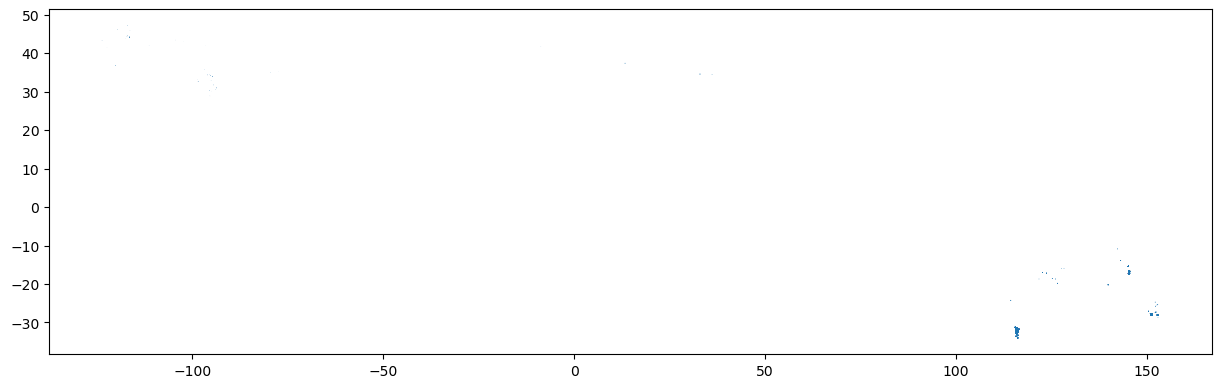

In [7]:
# Export 'intersection' GeoDataFrame to file

print('\n\n[gdf_LS_BRZ_intersection type]:')
print(type(gdf_LS_BRZ_intersection))
print('\n[gdf_LS_BRZ_intersection.is_valid]:')
print(gdf_LS_BRZ_intersection.is_valid.all())
print('\n[gdf_LS_BRZ_intersection]:')
print(gdf_LS_BRZ_intersection)

# create a plot of the GDF
gdf_LS_BRZ_intersection.plot(figsize=(15,15))

# Export geodataframe
gdf_LS_BRZ_intersection.to_file(f"gdf_LS_BRZ_intersection_{start_datetime}_{end_datetime}.geojson", driver='GeoJSON')
gdf_LS_BRZ_intersection.to_file(f"gdf_LS_BRZ_intersection_{start_datetime}_{end_datetime}.gpkg", driver='GPKG')